In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
import numpy as np
import argparse
from torch.utils.data import DataLoader
from fDNC.src.model import NIT_Registration, neuron_data_pytorch
import torch
import math
import time
import os
from torch import nn
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F



Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
DATA_PATH="/home/charles/Current_work/repos/fDNC_Neuron_ID/Data"
train_path = f"{DATA_PATH}/train_synthetic" 
eval_path = f"{DATA_PATH}/validation_synthetic"

model_path = "/home/charles/Current_work/repos/fDNC_Neuron_ID/fDNC/model/model.bin"

batch_size = 64
data_mode = 'all'

n_hidden = 128
f_trans = 0
p_rotate = 0
n_layer = 6

In [3]:
# loading the data
train_data = neuron_data_pytorch(train_path, batch_sz=batch_size, shuffle=True, rotate=True, mode=data_mode)
dev_data = neuron_data_pytorch(eval_path, batch_sz=batch_size, shuffle=False, rotate=True, mode=data_mode)


total volumes:236800
total volumes:12800


In [4]:
train_data_loader = DataLoader(train_data, shuffle=False, num_workers=1, collate_fn=train_data.custom_collate_fn)
dev_data_loader = DataLoader(dev_data, shuffle=False, num_workers=1, collate_fn=dev_data.custom_collate_fn)

In [130]:
# Get the first set of data
for data_batch in dev_data_loader:
    # print(t)
    pt_batch = data_batch['pt_batch']
    match_dict = data_batch['match_dict']
    ref_idx=data_batch['ref_i']
    
    # batch_loss, out = model(pt_batch, match_dict=match_dict, ref_idx=ref_idx , mode='eval')
    break


In [124]:
# The input isn't words, but actually locations, so use a custom encoder that can deal with that
# From: https://github.com/pytorch/examples/blob/master/word_language_model/model.py

class TransformerModel(nn.Module):

    def __init__(self, n_dim_input, ntoken, ninp, nhead=8, nhid=128, nlayers=6, dropout=0.5, device=None):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        # self.length_to_pad = ntoken
        self.src_mask = None
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(n_dim_input, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken) # Decode into categorical
        if device is None:
            self.device = "cuda:0" if torch.cuda.is_available() else "cpu"

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
            
        # src = self.pad_to_target_length(src)

        src = self.encoder(src) * math.sqrt(self.ninp)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return F.log_softmax(output, dim=-1)
    
    def pad_to_target_length(self, pts, pad_pt=None):
        if pad_pt is None:
            pad_pt = [0, 0, 0]
        list_of_padded_pts = []
        for s in pts:
            length_difference = self.length_to_pad - len(s)
            if length_difference > 0:
                padded = [pad_pt] * length_difference
                s = torch.tensor(torch.cat([s, torch.tensor(padded)]))
            elif length_difference < 0:
                s = s[:length_difference]
            list_of_padded_pts.append(s)
            # padded[:len(s)] = s
            # padding_var.append(padded)
        # output_tensor = list_of_padded_pts
        # output_tensor = torch.tensor(list_of_padded_pts, dtype=torch.float, device=self.device)
        output_tensor = torch.cat(list_of_padded_pts)
        return output_tensor  # torch.t(sents_var)

In [125]:
n_dim_input, ntoken, ninp = 3, 150, 128
model = TransformerModel(n_dim_input, ntoken, ninp)

In [126]:
dat = torch.unsqueeze(torch.from_numpy(pt_batch[0]), dim=0).float()
out = model(dat)

In [127]:
dat.shape, out.shape

(torch.Size([1, 107, 3]), torch.Size([1, 107, 150]))

Text(0.5, 1.0, 'Untrained encoding for neuron 1')

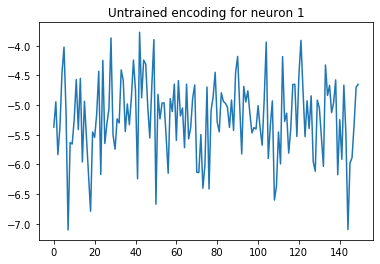

In [129]:
i_neuron = 1
plt.plot(np.squeeze(out[:, i_neuron, :].detach().numpy()));
plt.title(f"Untrained encoding for neuron {i_neuron}")

# Use the match_dict to create the target one-hot encoded embedding

In [165]:

target_labels = F.one_hot(torch.from_numpy(match_dict[1][:, 1]), num_classes=ntoken)

In [202]:
all_matches = []
all_valid_inds = []
for k, v in match_dict.items():
    if not isinstance(k, int):
        continue
    # if 'outlier' in k or 'unlabel' in k:
    #     continue
    num_to_pad = ntoken - len(v[:, 1])
    all_matches.append(np.pad(v[:, 1], (0, num_to_pad)))
    all_valid_inds.append(v[:, 0])
all_matches = np.stack(all_matches)

target_labels = F.one_hot(torch.from_numpy(all_matches), num_classes=ntoken)
target_labels.shape

torch.Size([64, 150, 150])

In [145]:
dat = torch.unsqueeze(torch.from_numpy(pt_batch[1]), dim=0).float()
out = model(dat)

# Lightning version

In [30]:
import os

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

# The input isn't words, but actually locations, so use a custom encoder that can deal with that
# From: https://github.com/pytorch/examples/blob/master/word_language_model/model.py

class LightningTransformerModel(LightningModule):

    def __init__(self, n_dim_input, ntoken, ninp, nhead=8, nhid=128, nlayers=6, dropout=0.5, device=None, 
                 learning_rate=2e-4):
        super(LightningTransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.learning_rate = learning_rate
        self.src_mask = None
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(n_dim_input, ninp)
        self.ninp = ninp
        self.ntoken = ntoken
        self.decoder = nn.Linear(ninp, ntoken) # Decode into categorical
        # if device is None:
        #     self.device = "cuda:0" if torch.cuda.is_available() else "cpu"

        self.init_weights()
        
        self.criterion = nn.BCELoss()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=False):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
            
        src = self.encoder(src) * math.sqrt(self.ninp)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        # return F.log_softmax(output, dim=-1)
        return F.softmax(output, dim=-1)

    def training_step(self, batch, batch_idx):
        loss, _ = self._calc_loss(batch)
        self.log("my_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, predictions = self._calc_loss(batch)
        # preds = torch.argmax(predictions, dim=1)
        # self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        # self.log("val_acc", self.accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def _calc_loss(self, batch):
        x, y = self._unpack_batch_and_pad(batch)
        predictions = self(x)
        loss = self.criterion(predictions, y)
        return loss, predictions
    
    def _unpack_batch_and_pad(self, batch, to_pad=True):
        all_short_x = batch['pt_batch']
        x = []
        for short_x in all_short_x:
            if to_pad:
                num_to_pad = self.ntoken - len(short_x)
                short_x = torch.unsqueeze(torch.from_numpy(np.pad(short_x, ((0, num_to_pad), (0, 0)))), dim=0).float()
            else:
                short_x = torch.from_numpy(short_x).float()
            x.append(short_x)
        x = torch.cat(x)
        match_dict = batch['match_dict']
        y = self._convert_all_matches_to_one_hot(match_dict, to_pad)
        # ref_idx=batch['ref_i']
        return x.to(self.device), y.to(self.device)
    
    def _convert_matches_to_one_hot(self, match_dict, i, to_pad):
        # match_dict may not be in monotonic order, or may skip some
        # For now, always pad
        target_labels = torch.zeros((self.ntoken, self.ntoken))
        for this_ind, ref_ind in match_dict[i]:
            target_labels[this_ind, :] = F.one_hot(torch.tensor(ref_ind), num_classes=self.ntoken)
        # these_vals = match_dict[i][:, 1]
        # these_ind = match_dict[i][:, 0]
        # if to_pad:
        #     num_to_pad = ntoken - len(these_vals)
        #     these_vals = np.pad(these_vals, (0, num_to_pad))
        # target_labels = F.one_hot(torch.from_numpy(these_vals), num_classes=self.ntoken)
        return target_labels
    
    def _convert_all_matches_to_one_hot(self, match_dict, to_pad):
        target_labels = []
        # target_labels = torch.zeros((1, ))
        for batch_key, _ in match_dict.items():
            if not isinstance(batch_key, int):
                continue
            if to_pad:
                target_labels.append(torch.unsqueeze(self._convert_matches_to_one_hot(match_dict, batch_key, to_pad=to_pad), dim=0).float())
            else:
                target_labels.append(self._convert_matches_to_one_hot(match_dict, batch_key, to_pad=to_pad).float())
        return torch.cat(target_labels)
    
    def _get_valid_ind(self, match_dict):
        valid_ind = []
        for k, v in match_dict.items():
            if not isinstance(k, int):
                continue
            valid_ind.append(torch.from_numpy(v[:, 0]))
        return valid_ind

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        DATA_PATH="/home/charles/Current_work/repos/fDNC_Neuron_ID/Data"
        train_path = f"{DATA_PATH}/train_synthetic" 
        eval_path = f"{DATA_PATH}/validation_synthetic"
        
        # loading the data
        self.train_data = neuron_data_pytorch(train_path, batch_sz=batch_size, shuffle=True, rotate=True, mode=data_mode)
        self.dev_data = neuron_data_pytorch(eval_path, batch_sz=batch_size, shuffle=False, rotate=True, mode=data_mode)


#     def setup(self, stage=None):

#         # Assign train/val datasets for use in dataloaders
#         if stage == "fit" or stage is None:
#             mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
#             self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

#         # Assign test dataset for use in dataloader(s)
#         if stage == "test" or stage is None:
#             self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, shuffle=False, num_workers=1, collate_fn=self.train_data.custom_collate_fn)

    def val_dataloader(self):
        return DataLoader(self.dev_data, shuffle=False, num_workers=1, collate_fn=self.dev_data.custom_collate_fn)

    # def test_dataloader(self):
    #     return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [31]:
n_dim_input, ntoken, ninp = 3, 180, 128

model = LightningTransformerModel(n_dim_input, ntoken, ninp)


AVAIL_GPUS = min(1, torch.cuda.device_count())

trainer = Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=100,
    progress_bar_refresh_rate=100,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [32]:
# model.prepare_data()
# for batch in model.train_dataloader():
#     model.validation_step(batch, 0)
#     break

In [33]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | transformer_encoder | TransformerEncoder | 597 K 
1 | encoder             | Linear             | 512   
2 | decoder             | Linear             | 23.2 K
3 | criterion           | BCELoss            | 0     
-----------------------------------------------------------
621 K     Trainable params
0         Non-trainable params
621 K     Total params
2.485     Total estimated model params size (MB)


total volumes:236800
total volumes:12800


Validation sanity check: 0it [00:00, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Process Process-220:
Process Process-205:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/charles/anaconda3/envs/torch/lib/python3.7/multiprocessing/util.py", line 300,

# Look at some encodings

In [8]:
dev_data_loader = model.train_dataloader()

In [9]:
# Get the first set of data
for data_batch in dev_data_loader:
    # print(t)
    pt_batch = data_batch['pt_batch']
    match_dict = data_batch['match_dict']
    ref_idx=data_batch['ref_i']
    
    # batch_loss, out = model(pt_batch, match_dict=match_dict, ref_idx=ref_idx , mode='eval')
    break


In [20]:
out = model._convert_all_matches_to_one_hot(match_dict, to_pad=True)
out.shape

torch.Size([64, 180, 180])

In [10]:
dat = torch.unsqueeze(torch.from_numpy(pt_batch[0]), dim=0).float()
out = model(dat)

In [11]:
dat.shape, out.shape

(torch.Size([1, 106, 3]), torch.Size([1, 106, 180]))

Text(0.5, 1.0, 'Untrained encoding for neuron 1')

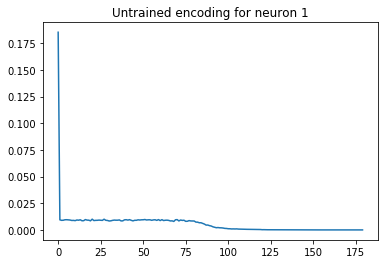

In [12]:
i_neuron = 1
plt.plot(np.squeeze(out[:, i_neuron, :].detach().numpy()));
plt.title(f"Untrained encoding for neuron {i_neuron}")

Text(0.5, 1.0, 'Untrained encoding for neuron 100')

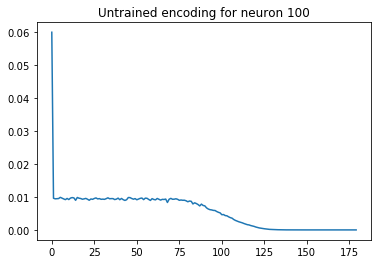

In [17]:
i_neuron = 100
plt.plot(np.squeeze(out[:, i_neuron, :].detach().numpy()));
plt.title(f"Untrained encoding for neuron {i_neuron}")